# Simple-Attention 

The notenook introduces simple attention mechanism implemented with Zoo Keras API.

## Dense layer with Attention

Let's consider this Hello World example:

A vector v of 32 values as input to the model (simple feedforward neural network).
v[1] = target.
Target is binary (either 0 or 1).
All the other values of the vector v (v[0] and v[2:32]) are purely random and do not contribute to the target.
We expect the attention to be focused on v[1] only, or at least strongly:

In [1]:
import numpy as np

np.random.seed(1337)  # for reproducibility
from zoo.common.nncontext import *
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.keras.layers import Dense, Input
from zoo.pipeline.api.keras.engine.topology import merge

def build_attention_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(32)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

def get_data(n, input_dim, attention_column=1):
    """
    x[attention_column] = y
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

if __name__ == '__main__':

    sparkConf = create_spark_conf()
    sc = init_nncontext(sparkConf)

    N = 10000
    input_dim = 32

    inputs_1, outputs = get_data(N, input_dim)

    m = build_attention_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit(inputs_1, outputs, nb_epoch=20, batch_size=64)

    # Attention vector corresponds to the second matrix.
    # The first one is the Inputs output.
    test_input = np.ones((1, 32))
    attention_layer = m.get_layer("attention_vec")
    attention_vector = attention_layer.predict(test_input)[0]
    print('attention =', attention_vector)



creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasMerge
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdam
creating: createBCECriterion
creating: createZooKerasAccuracy
None
attention = [ 0.01627639  0.67928052  0.01461436  0.01809778  0.00312758  0.00876188
  0.00291414  0.00647227  0.00125693  0.01020642  0.00797412  0.00550699
  0.00772522  0.00843727  0.02389522  0.01456996  0.00676908  0.01222085
  0.01922013  0.01760512  0.01703159  0.00141871  0.00414275  0.01018488
  0.01190639  0.01736827  0.00742603  0.00983353  0.01146181  0.00836217
  0.00581221  0.01011952]


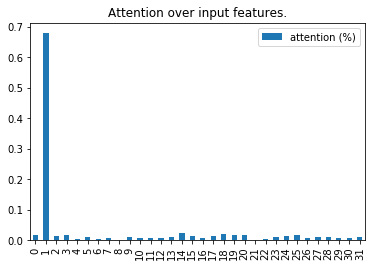

In [2]:
# plot part.
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(attention_vector,
            columns=['attention (%)']).plot(kind='bar',
                                            title='Attention over input features.')
plt.show()

We can clearly see that the network figures this out for the inference.

Behind the scenes

The attention mechanism can be implemented in three lines with Keras:
```
inputs = Input(shape=(input_dims,))
attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(inputs)
attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
```

We apply a Dense - Softmax layer with the same number of output parameters than the Input layer. The attention matrix has a shape of input_dims x input_dims here.

Then we merge the Inputs layer with the attention layer by multiplying element-wise.


## Recurrent Layers (LSTM, GRU...) with Attention

Application of attention at input level

We consider the same example as the one used for the Dense layers. The attention index is now on the 10th value. We therefore expect an attention spike around this value. There are two main ways to apply attention to recurrent layers:

Directly on the inputs (same as the Dense example above): APPLY_ATTENTION_BEFORE_LSTM = True

creating: createZooKerasInput
creating: createZooKerasPermute
creating: createZooKerasDense
creating: createZooKerasPermute
creating: createZooKerasMerge
creating: createZooKerasLSTM
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdam
creating: createBCECriterion
creating: createZooKerasAccuracy
[ 0.01060883  0.0097768   0.01198363  0.00716008  0.01210861  0.01906555
  0.02104882  0.00955848  0.00624979  0.00591045  0.75422114  0.00743659
  0.00564696  0.00476283  0.01417882  0.01215875  0.00941554  0.05513887
  0.02209737  0.00147208]


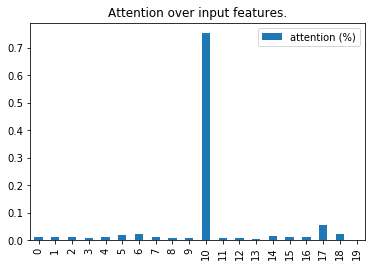

In [3]:
import numpy as np

np.random.seed(1001)  # for reproducibility
from zoo.common.nncontext import *
from zoo.pipeline.api.keras.layers.recurrent import LSTM
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.keras.layers import Dense, Input, Permute, Reshape, Flatten
from zoo.pipeline.api.keras.engine.topology import merge
from bigdl.util.common import RNG

rng = RNG()
rng.set_seed(1000)
INPUT_DIM = 2
TIME_STEPS = 20

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(INPUT_DIM)
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    target = x[attention_column].
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


if __name__ == '__main__':

    N = 300000
    inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)
    
    # apply attention before LSTM
    m = model_attention_applied_before_lstm()


    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    m.fit(inputs_1, outputs, nb_epoch=1, batch_size=64)

    # get attention vector
    x = np.ones((1, TIME_STEPS, INPUT_DIM))
    attention_model = m.new_graph(['attention_vec'])
    attention_vector = attention_model.predict(x).collect()[0]
    print(attention_vector[:, 0])

    import matplotlib.pyplot as plt
    import pandas as pd
    attention_vector_final = attention_vector[:, 0]
    pd.DataFrame(attention_vector_final,
                 columns=['attention (%)']).plot(kind='bar', title='Attention over input features.')
    plt.show()

creating: createZooKerasInput
creating: createZooKerasLSTM
creating: createZooKerasPermute
creating: createZooKerasDense
creating: createZooKerasPermute
creating: createZooKerasMerge
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdam
creating: createBCECriterion
creating: createZooKerasAccuracy
[  3.41284118e-04   2.78609077e-04   3.19919258e-04   3.36405647e-04
   3.06878006e-04   2.98665982e-04   2.53600243e-04   3.56121367e-04
   3.61470476e-04   3.57568555e-04   9.94164884e-01   6.47786737e-06
   5.03655814e-04   2.75031722e-04   3.40831059e-04   3.11097654e-04
   3.11133277e-04   2.65544310e-04   3.25361587e-04   2.85356771e-04]


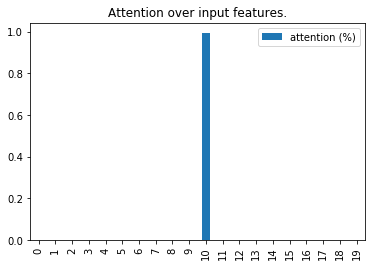

In [4]:
    # apply attention after LSTM
    m = model_attention_applied_after_lstm()

    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    m.fit(inputs_1, outputs, nb_epoch=1, batch_size=64)

    # get attention vector
    x = np.ones((1, TIME_STEPS, INPUT_DIM))
    attention_model = m.new_graph(['attention_vec'])
    attention_vector = attention_model.predict(x).collect()[0]
    print(attention_vector[:, 0])

    # plot part
    import matplotlib.pyplot as plt
    import pandas as pd
    attention_vector_final = attention_vector[:, 0]
    pd.DataFrame(attention_vector_final,
                 columns=['attention (%)']).plot(kind='bar', title='Attention over input features.')
    plt.show()

We can clearly see that the network figures out that the 10th feature is the most important feature that's worth more attention.

## Summary
In this notebook, we use the Keras API in Analytics Zoo to build some simple models with attention mechanism. In both Dense and LSTM examples, the attention layer can capture the important features and 